In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import itertools
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

In [2]:
df=pd.read_csv('product e.csv', parse_dates=['Month-Year'])


In [3]:
sales_e= df.drop(['Product Name','Product Category','Month','Year','Month No.'],axis=1)

In [4]:
sales_e = sales_e.rename(columns={'Month-Year': 'ds',
                        'Sales': 'y'})

sales_e.head(5)

,ds,y,Market Size,Marketing Expense
0,2019-01-01,57650,303130,2978499
1,2019-02-01,66035,347219,3411712
2,2019-03-01,88208,463807,4557285
3,2019-04-01,74712,392844,3860011
4,2019-05-01,61172,321649,3160464


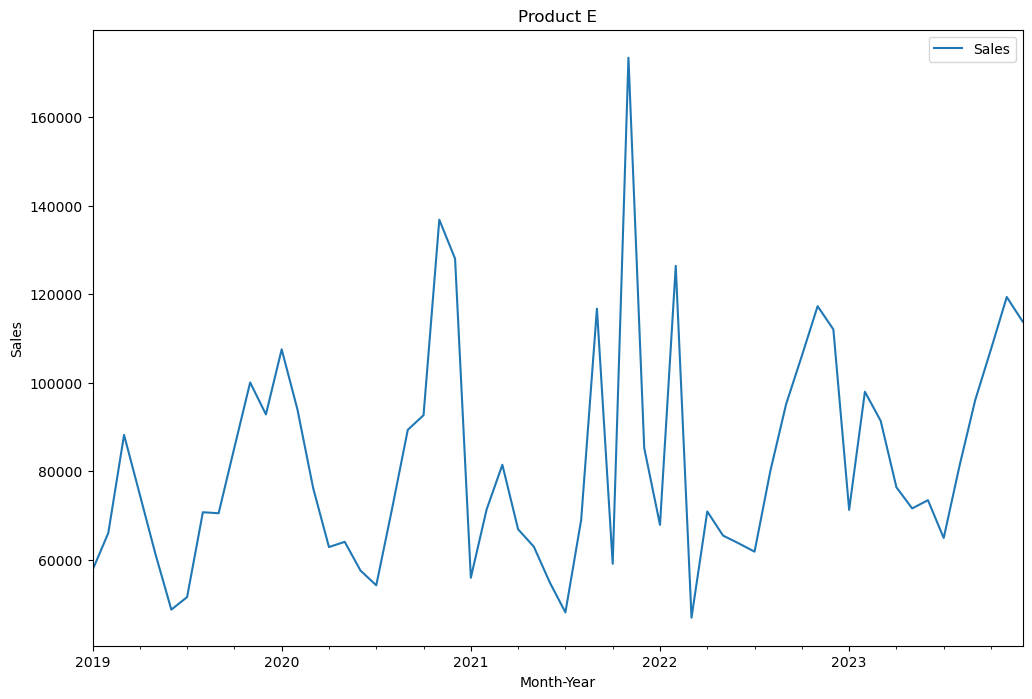

In [5]:
ax = sales_e.set_index('ds')['y'].plot(figsize=(12, 8))
ax.set_ylabel('Sales')
ax.set_xlabel('Month-Year')
plt.title('Product E')
plt.legend(['Sales'])
plt.show()


In [6]:
train= sales_e[:54]
test=sales_e[54:]

In [7]:
changepoint_prior_scale_range = [0.001, 0.01, 0.1,0.2, 0.3, 0.5]
seasonality_prior_scale_range = [0.01, 0.1, 1.0, 3.0, 5.0, 10.0]
seasonality_mode_range = ['additive', 'multiplicative']

param_grid = {  
    'changepoint_prior_scale': changepoint_prior_scale_range,
    'seasonality_prior_scale': seasonality_prior_scale_range,
    'seasonality_mode' : seasonality_mode_range
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)
    m.add_regressor('Market Size')
    m.add_regressor('Marketing Expense')
    m.fit(train)
    df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '180 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

00:13:39 - cmdstanpy - INFO - Chain [1] start processing
00:13:39 - cmdstanpy - INFO - Chain [1] done processing
00:13:42 - cmdstanpy - INFO - Chain [1] start processing
00:13:42 - cmdstanpy - INFO - Chain [1] done processing
00:13:45 - cmdstanpy - INFO - Chain [1] start processing
00:13:45 - cmdstanpy - INFO - Chain [1] done processing
00:13:48 - cmdstanpy - INFO - Chain [1] start processing
00:13:48 - cmdstanpy - INFO - Chain [1] done processing
00:13:51 - cmdstanpy - INFO - Chain [1] start processing
00:13:51 - cmdstanpy - INFO - Chain [1] done processing
00:13:53 - cmdstanpy - INFO - Chain [1] start processing
00:13:53 - cmdstanpy - INFO - Chain [1] done processing
00:13:59 - cmdstanpy - INFO - Chain [1] start processing
00:14:01 - cmdstanpy - INFO - Chain [1] done processing
00:14:03 - cmdstanpy - INFO - Chain [1] start processing
00:14:03 - cmdstanpy - INFO - Chain [1] done processing
00:14:07 - cmdstanpy - INFO - Chain [1] start processing
00:14:08 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                     0.01         additive   
1                     0.001                     0.01   multiplicative   
2                     0.001                     0.10         additive   
3                     0.001                     0.10   multiplicative   
4                     0.001                     1.00         additive   
..                      ...                      ...              ...   
67                    0.500                     3.00   multiplicative   
68                    0.500                     5.00         additive   
69                    0.500                     5.00   multiplicative   
70                    0.500                    10.00         additive   
71                    0.500                    10.00   multiplicative   

            rmse  
0   33315.750283  
1   31280.594016  
2   30641.229917  
3   26871.186158  
4   30179.586356  
..       

In [8]:
tuning_results.sort_values('rmse',ascending=True)

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,rmse
35,0.100,10.00,multiplicative,25936.644547
53,0.300,1.00,multiplicative,26049.070102
69,0.500,5.00,multiplicative,26127.746020
45,0.200,5.00,multiplicative,26171.614360
57,0.300,5.00,multiplicative,26220.470522
...,...,...,...,...
12,0.010,0.01,additive,32907.106960
24,0.100,0.01,additive,32911.903086
0,0.001,0.01,additive,33315.750283
68,0.500,5.00,additive,34108.887544


In [9]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}


In [10]:
# Create a Prophet model
#model = Prophet(changepoint_prior_scale=0.0100, seasonality_prior_scale=4.006, interval_width=0.95)
model = Prophet(changepoint_prior_scale=0.1, seasonality_prior_scale=10.00, seasonality_mode= 'multiplicative',interval_width=0.95)
model.add_regressor('Market Size')
model.add_regressor('Marketing Expense')

In [11]:
model.fit(train)

00:30:42 - cmdstanpy - INFO - Chain [1] start processing
00:30:42 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
len(test)

6

In [14]:
# Create a DataFrame for future dates (including 2023)
future_dates = model.make_future_dataframe(periods=len(test), freq='MS')  # 6 months in 2023

In [15]:
future_dates['Market Size'] = sales_e['Market Size']
future_dates['Marketing Expense'] = sales_e['Marketing Expense']

In [16]:
future_dates

,ds,Market Size,Marketing Expense
0,2019-01-01,303130,2978499
1,2019-02-01,347219,3411712
2,2019-03-01,463807,4557285
3,2019-04-01,392844,3860011
4,2019-05-01,321649,3160464
5,2019-06-01,256180,2517181
6,2019-07-01,271087,2663652
7,2019-08-01,371885,3654074
8,2019-09-01,370707,3642501
9,2019-10-01,526105,5169414


In [17]:
# Make predictions for the future
forecast = model.predict(future_dates)

In [18]:
forecasted_df=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6)

In [19]:
forecasted_df

,ds,yhat,yhat_lower,yhat_upper
54,2023-07-01,59049.913089,35263.459669,81531.856923
55,2023-08-01,80950.616774,58416.309533,104812.042932
56,2023-09-01,92047.658874,67283.207532,114384.219942
57,2023-10-01,100473.387982,77941.585821,123858.701874
58,2023-11-01,120242.872358,96530.015215,142473.364996
59,2023-12-01,102759.755587,79881.713977,124661.851157


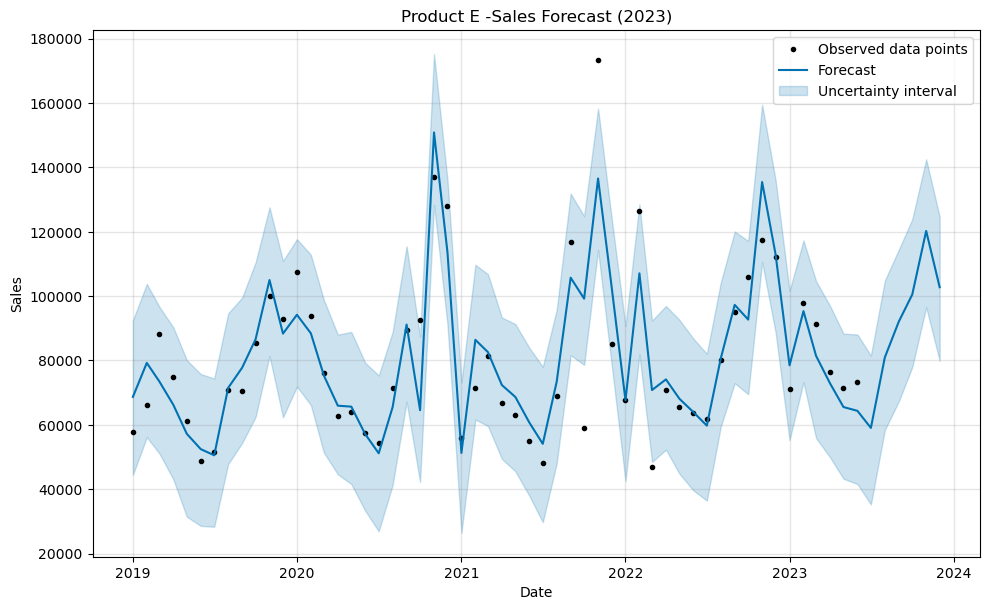

In [20]:
fig = model.plot(forecast, include_legend=True, uncertainty=True)
plt.title('Product E -Sales Forecast (2023)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

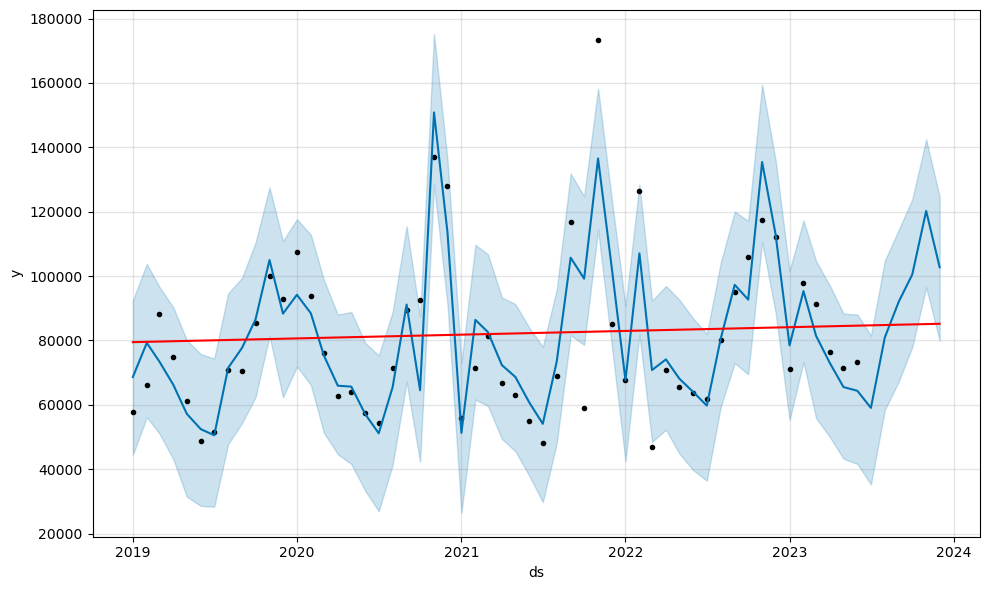

In [21]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

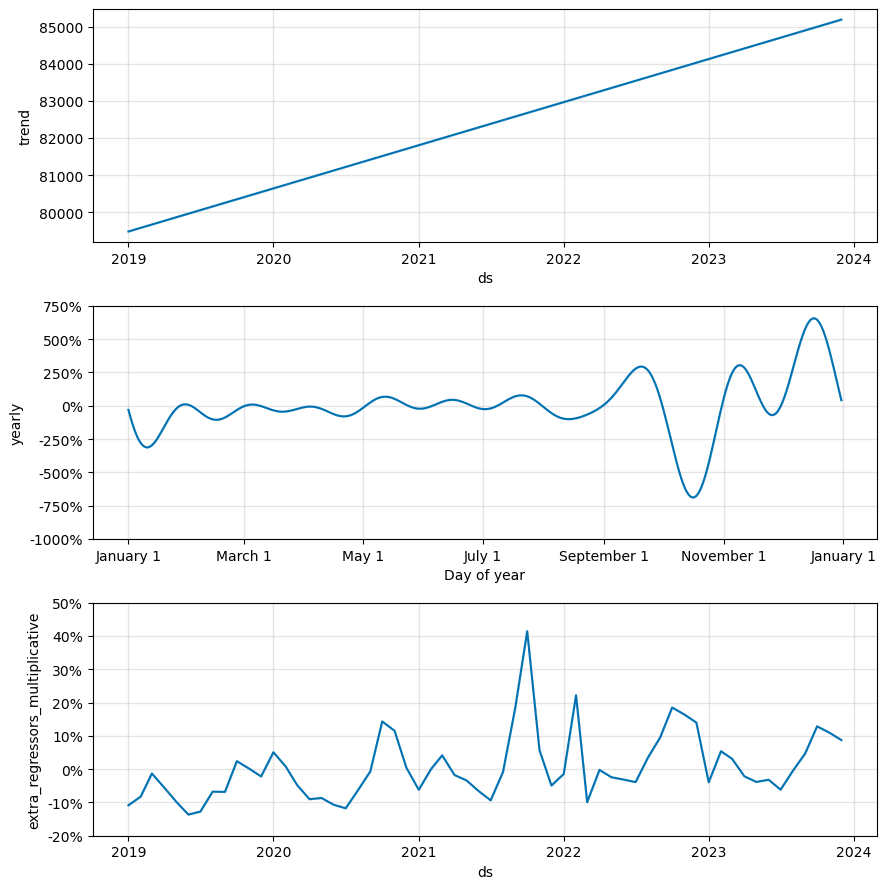

In [22]:
fig2 = model.plot_components(forecast)

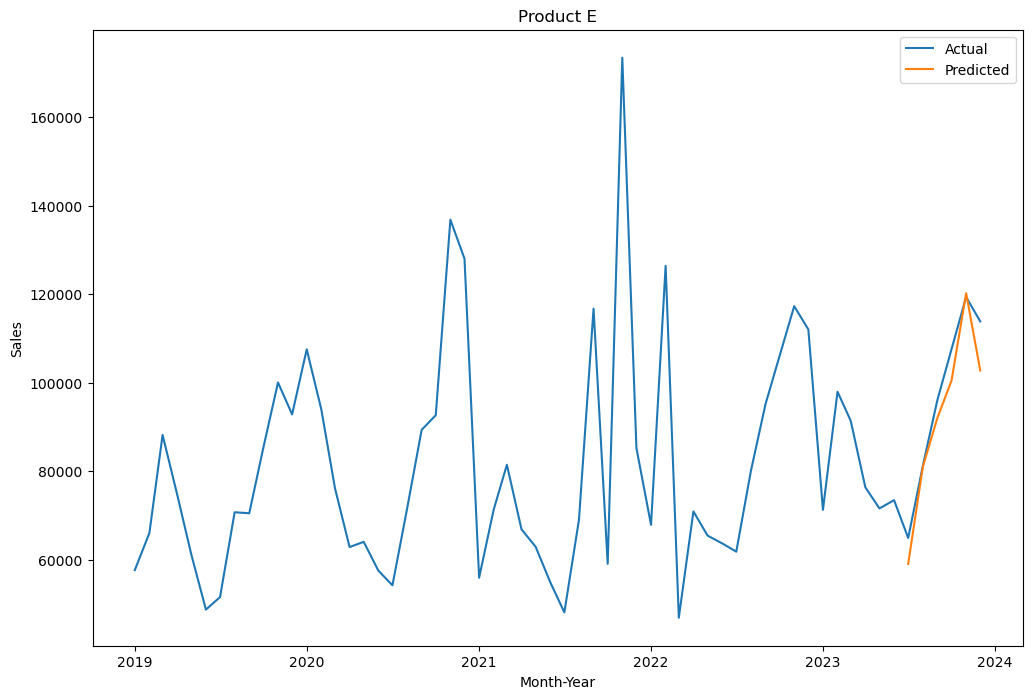

In [23]:
# Reset index of sales_b DataFrame
sales_e_reset_index = sales_e.reset_index()

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(sales_e_reset_index['ds'], sales_e_reset_index['y'], label='Actual')
plt.plot(forecasted_df['ds'], forecasted_df['yhat'], label='Predicted')
plt.title('Product E')
plt.xlabel('Month-Year')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [24]:
#model evaluation

In [25]:
pred=forecasted_df['yhat']
test_df=test['y']

In [26]:
mae_fb= mean_absolute_error(test_df,pred)
mse_fb=mean_squared_error(test_df, pred)
mape_fb= mean_absolute_percentage_error(test_df,pred)
rmse_fb= np.sqrt(mean_squared_error(test_df,pred))


print(f'MAE - FB PROPHET: {mae_fb:.3f}')
print(f'MAPE - FB PROPHET: {mape_fb:.3f}')
print(f'MSE - FB PROPHET: {mse_fb:.3f}')
print(f'RMSE - FB PROPHET: {rmse_fb:.3f}')

MAE - FB PROPHET: 4867.257
MAPE - FB PROPHET: 0.051
MSE - FB PROPHET: 37522979.371
RMSE - FB PROPHET: 6125.600


In [27]:
#Set initial window to 2 years (24 months), period to 1 year (12 months), and horizon to 1 year (12 months)
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='180 days', parallel="processes")

In [28]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,24 days,4.579554e+06,2139.989205,2051.332054,0.034590,0.034590,0.033992,0.5
1,25 days,6.637856e+06,2576.403693,2574.969810,0.039733,0.039733,0.039770,1.0
2,29 days,1.669774e+07,4086.286952,3852.204871,0.056722,0.056722,0.055844,1.0
3,51 days,1.370447e+07,3701.955301,2836.116571,0.039900,0.039900,0.038620,1.0
4,55 days,8.611714e+08,29345.722203,20977.726195,0.167452,0.167452,0.199696,0.5
5,56 days,8.612658e+08,29347.330108,21064.522577,0.168080,0.168080,0.200298,0.5
6,60 days,3.167052e+07,5627.656500,4282.070180,0.044431,0.044431,0.046124,1.0
7,82 days,1.109698e+08,10534.221857,10271.531886,0.094501,0.094501,0.099293,0.5
8,83 days,8.187806e+08,28614.343246,25530.740235,0.464042,0.464042,0.347889,0.0
9,87 days,7.416515e+08,27233.278940,20314.378326,0.421473,0.421473,0.302107,0.5


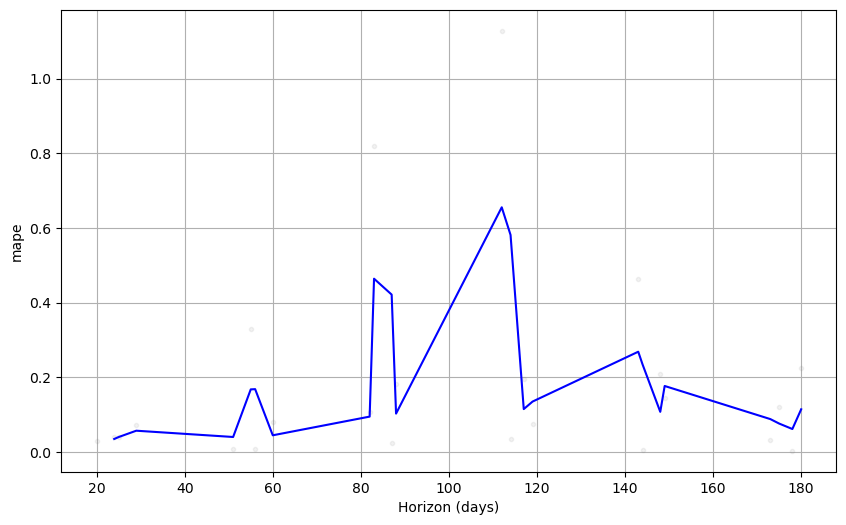

In [29]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [30]:
test_df

54     64909
55     81175
56     96096
57    107582
58    119374
59    113854
Name: y, dtype: int64

In [31]:
pred

54     59049.913089
55     80950.616774
56     92047.658874
57    100473.387982
58    120242.872358
59    102759.755587
Name: yhat, dtype: float64